# Analyzing the effect of proposed homeless sleeping limits in Los Angeles

By [Matt Stiles](https://www.latimes.com/la-bio-matt-stiles-staff.html) and [Ryan Menezes](https://www.latimes.com/staff/ryan-menezes)

This notebook documents the process of examining the effects of proposed sleeping restriction on the homeless population in Los Angeles. The proposed city rules would limit sleeping in 500-foot buffer zones around selected property types, including schools, parks and childcare facilities, among others. This analysis draws those buffer zones around the properties, which are identified in government mapping data, and calculates the area included in the limits citywide and by neighborhood.  

### Load libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas import DataFrame
%matplotlib inline

### Read raw data from city, county GIS portals

In [2]:
rawfiles = {
    # childcare spatial file uses points to avoid assigning single-location facilities to multi-location parcels
    # bikeways not included because they don't need to be buffered
    # 'bikeways': 'raw/la_city_bikeways.geojson',
    # homeless shelters excluded until recent locations file acquired
    #'homeless': 'raw/la_county_gis_homeless_shelters_1566703407847.geojson',
    'childcare': 'raw/la_city_gis_childcare_clipped.geojson',
    'parks': 'raw/la_city_parks_1566703413127.geojson',
    'public_schools': 'raw/lausd_schools_boundaries_1566703408821.geojson',
    'private_schools': 'raw/la_county_private_school_parcels.geojson',
    'special_venues': 'raw/la_city_special_venues.geojson'
}

### Reproject spatial data for distance calculations

In [3]:
def reproject(i, o, c = 3310):
    return f'ogr2ogr processed/{o}_{c}.geojson -t_srs "EPSG:3310" {i}'

In [4]:
for r in rawfiles:
    s = reproject(rawfiles[r], r)
    print(s)
    !$s

ogr2ogr processed/childcare_3310.geojson -t_srs "EPSG:3310" raw/la_city_gis_childcare_clipped.geojson
ogr2ogr processed/parks_3310.geojson -t_srs "EPSG:3310" raw/la_city_parks_1566703413127.geojson
ogr2ogr processed/public_schools_3310.geojson -t_srs "EPSG:3310" raw/lausd_schools_boundaries_1566703408821.geojson
ogr2ogr processed/private_schools_3310.geojson -t_srs "EPSG:3310" raw/la_county_private_school_parcels.geojson
ogr2ogr processed/special_venues_3310.geojson -t_srs "EPSG:3310" raw/la_city_special_venues.geojson


### Dataframes from city, county spatial files

# SHOULD WE BUFFER BEFORE CONCAT??

In [5]:
alldata = pd.concat([gpd.read_file(f'processed/{r}_3310.geojson') for r in rawfiles])[['geometry']]

/Users/mhustiles/.virtualenvs/twitter/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
alldata.crs

{'init': 'epsg:3310'}

In [7]:
alldata.head()

,geometry
0,(POINT (163813.8930618464 -439249.2645478053))
1,(POINT (163606.8981438576 -439216.8566115182))
2,(POINT (162089.5895063573 -439290.9106377037))
3,(POINT (159980.3012114689 -443436.5564146922))
4,(POINT (159887.4485011428 -436884.1232245923))


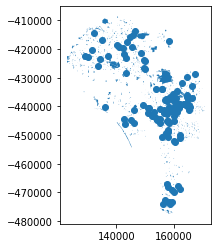

In [8]:
alldata.plot()

In [9]:
alldata['buffer'] = alldata.buffer(152.4)

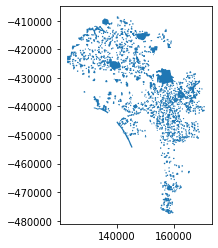

In [10]:
gpd.GeoSeries(alldata['buffer']).plot()

In [11]:
alldata['dummy'] = 'abc'

In [12]:
alldata.head()

,geometry,buffer,dummy
0,(POINT (163813.8930618464 -439249.2645478053)),POLYGON ((163966.2930618464 -439249.2645478053...,abc
1,(POINT (163606.8981438576 -439216.8566115182)),POLYGON ((163759.2981438576 -439216.8566115182...,abc
2,(POINT (162089.5895063573 -439290.9106377037)),POLYGON ((162241.9895063573 -439290.9106377037...,abc
3,(POINT (159980.3012114689 -443436.5564146922)),POLYGON ((160132.7012114689 -443436.5564146922...,abc
4,(POINT (159887.4485011428 -436884.1232245923)),POLYGON ((160039.8485011428 -436884.1232245923...,abc


In [13]:
allbuffers = gpd.GeoDataFrame(alldata[['dummy','buffer']], geometry='buffer').dissolve(by = 'dummy')

In [14]:
allbuffers

,buffer
dummy,
abc,(POLYGON ((155277.2620720536 -475419.603562016...


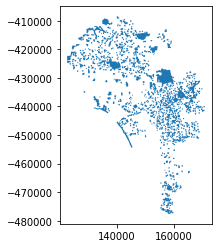

In [15]:
allbuffers.plot()

In [16]:
allbuffers.to_file('buffered/combined-buffers.geojson', driver='GeoJSON')

In [17]:
allbuffers.crs

In [44]:
allbuffers.geometry.area  / 2590000

dummy
abc    3.685147e+08
dtype: float64

In [19]:
hoods = gpd.read_file('raw/la-county-neighborhoods-current.geojson')

In [20]:
hoods['hood_type'] = hoods['metadata'].apply(dict).apply(lambda x: x['type'])

In [21]:
hoods.to_crs({'init': 'epsg:3310'}, inplace=True)

In [22]:
hoods.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry,hood_type
0,L.A. County Neighborhood (Current),acton,Acton,acton-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 39.3391089485, 'type': 'unincorporate...",/1.0/boundary/acton-la-county-neighborhood-cur...,(POLYGON ((164907.1721133307 -384800.650005886...,unincorporated-area
1,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,adams-normandie-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 0.805350187789, 'type': 'segment-of-a...",/1.0/boundary/adams-normandie-la-county-neighb...,(POLYGON ((156139.6401248095 -440624.691527145...,segment-of-a-city
2,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,agoura-hills-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 8.14676029818, 'type': 'standalone-ci...",/1.0/boundary/agoura-hills-la-county-neighborh...,(POLYGON ((114132.3855756644 -426762.559576650...,standalone-city
3,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,agua-dulce-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 31.4626319451, 'type': 'unincorporate...",/1.0/boundary/agua-dulce-la-county-neighborhoo...,(POLYGON ((160091.8405679099 -382746.646477827...,unincorporated-area
4,L.A. County Neighborhood (Current),alhambra,Alhambra,alhambra-la-county-neighborhood-current,/1.0/boundary-set/la-county-neighborhoods-curr...,"{'sqmi': 7.62381430605, 'type': 'standalone-ci...",/1.0/boundary/alhambra-la-county-neighborhood-...,(POLYGON ((173279.8293033192 -432798.533470016...,standalone-city


In [23]:
lahoods = hoods.loc[hoods.hood_type == 'segment-of-a-city', ['name', 'geometry']]

In [24]:
lahoods.head()

,name,geometry
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...


In [25]:
lahoods.head()

,name,geometry
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...


Puts the buffer shape on each line

In [26]:
lahoods['buffers'] = lahoods['name'].apply(lambda x: allbuffers['buffer'][0])

In [27]:
lahoods.head()

,name,geometry,buffers
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,(POLYGON ((155277.2620720536 -475419.603562016...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...,(POLYGON ((155277.2620720536 -475419.603562016...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,(POLYGON ((155277.2620720536 -475419.603562016...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...,(POLYGON ((155277.2620720536 -475419.603562016...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...,(POLYGON ((155277.2620720536 -475419.603562016...


In [28]:
len(lahoods)

114

In [29]:
lahoods['hits_buffer'] = lahoods.apply(lambda x: x.geometry.intersects(x.buffers), axis = 1)

How many of the lahoods hit the buffer?

In [30]:
lahoods['hits_buffer'].sum()

114

In [31]:
lahoods['intersection'] = lahoods.apply(lambda x: x.geometry.intersection(x.buffers), axis=1)

In [32]:
lahoods.head()

,name,geometry,buffers,hits_buffer,intersection
1,Adams-Normandie,(POLYGON ((156139.6401248095 -440624.691527145...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((156139.6401248095 -440624.691527145...
9,Arleta,(POLYGON ((145361.3096072993 -420096.183241406...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((143859.8887858134 -419132.018329077...
10,Arlington Heights,(POLYGON ((155472.5469032949 -438950.195603739...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((155507.5774555412 -438947.887246884...
13,Atwater Village,(POLYGON ((158739.6492951899 -427752.278756475...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((158739.6492951899 -427752.278756475...
17,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((151900.664113194 -442106.3025537037...


In [33]:
lahoods['hood_area'] = lahoods.geometry.area / 2590000

In [34]:
lahoods['buffer_area'] = lahoods['intersection'].apply(lambda x: x.area / 2590000)

In [35]:
lahoods['pct_of_hood_in_buffer'] = lahoods.buffer_area / lahoods.hood_area

In [36]:
lahoods.sort_values('pct_of_hood_in_buffer', ascending=False)

,name,geometry,buffers,hits_buffer,intersection,hood_area,buffer_area,pct_of_hood_in_buffer
89,Griffith Park,(POLYGON ((156829.1284531329 -427266.164410656...,(POLYGON ((155277.2620720536 -475419.603562016...,True,POLYGON ((156829.1284531329 -427266.1644106563...,5.835412,5.831311,0.999297
92,Hansen Dam,(POLYGON ((150213.0023347829 -414549.544432659...,(POLYGON ((155277.2620720536 -475419.603562016...,True,POLYGON ((150213.0023347829 -414549.5444326596...,1.965736,1.963418,0.998821
74,Elysian Park,(POLYGON ((163782.7920108401 -436433.284509371...,(POLYGON ((155277.2620720536 -475419.603562016...,True,POLYGON ((163782.7920108401 -436433.2845093715...,1.643644,1.616573,0.983530
200,Sepulveda Basin,(POLYGON ((139744.5472696587 -424348.804661298...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((139744.5998036747 -424352.089170091...,3.135845,2.993854,0.954720
257,Westlake,(POLYGON ((158709.9269350781 -436196.146341535...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((159580.4575424944 -436520.473373194...,2.717338,1.746713,0.642803
151,Montecito Heights,(POLYGON ((168259.3272685921 -432090.137112584...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((168259.3272685921 -432090.137112584...,2.410771,1.469158,0.609414
173,Pico-Union,(POLYGON ((157225.9029746909 -438885.587617512...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((157956.9069593252 -438916.799876119...,1.670386,0.997983,0.597457
93,Harbor City,(POLYGON ((157351.5721386187 -465393.510194905...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((157519.8512510806 -466783.160752343...,2.577134,1.488245,0.577481
249,Watts,(POLYGON ((162293.5748314608 -449790.518718350...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((162293.5748314608 -449790.518718350...,2.121397,1.164347,0.548858
210,South Park,(POLYGON ((161064.6065343088 -444262.830132298...,(POLYGON ((155277.2620720536 -475419.603562016...,True,(POLYGON ((161064.6065343088 -444262.830132298...,1.406809,0.768288,0.546121


In [37]:
intersection_gdf = gpd.GeoDataFrame(lahoods[['name','intersection', 'pct_of_hood_in_buffer']], geometry = 'intersection')

In [38]:
intersection_gdf.to_file('buffered/buffers-by-hood.geojson', driver='GeoJSON')

In [39]:
export_hood_pct_table = pd.DataFrame(lahoods[['name','hood_area', 'buffer_area','pct_of_hood_in_buffer']]).sort_values('pct_of_hood_in_buffer', ascending=False)

In [40]:
export_hood_pct_table.to_csv('buffered/hood-breakdown.csv')